# Intelligent-driven Automatic Operational Modal Analysis i-AOMA
Marco Martino Rosso, Angelo Aloisio, Giuseppe Carlo Marano, and Giuseppe Quaranta

This code is running Monte Carlo (MC) Stochastic Subspace Identification covariance-based (SSI-cov)

Created on March 6 2023
@author: Marco Martino Rosso

## Import modules and classes

In [1]:
"""
Intelligent-driven Automatic Operational Modal Analysis i-AOMA
Marco Martino Rosso, Angelo Aloisio, Giuseppe Carlo Marano, and Giuseppe Quaranta

This code is running Monte Carlo (MC) Stochastic Subspace Identification covariance-based (SSI-cov)

Created on March 6 2023
@author: Marco Martino Rosso
"""
# %% Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'Poppins'


from ssicov.ssi import SsiCov
from ssicov.SDres import SdRes
from datapreprocessing.helpers import *
from user_definitions import *
from utilities.utils import *
from qmc.qmc_sampling import QmcSampler
from kde.kdepy import Kde
from rfcore.RFcore import RfCore
from convergencecheck.convcheck import ConvCheck

## i-AOMA phase 1 exploratory

In [2]:
## i-AOMA phase 1 exploratory

# Import data and decimate
create_results_folder(RESULTS_PATH+'/Phase1')
data = import_data(DATA_FILE)

data, fs = datadecimate(data, fs=SAMPLING_FREQUENCY, q=DECIMATION_FACTOR) #fs: [Hz] Decimated sampling frequency

if DATAFILTERING:
    data = datafiltering(data, fs, BUTTERWORTH_DESIGN)

visualize_plot_signals(data, PLOTSIGNALS, RESULTS_PATH+'/Phase1', fs, SAVEPLOTSIGNALS, labelsformat=['Time [s]','Acceleration [mm/s^2]'])
svPSD = visualize_plot_PSD(data, PLOTSVDOFPSD, RESULTS_PATH+'/Phase1', fs, SAVEPLOTSVDOFPSD)

# i-AOMA Phase 1 
print('\n\ni-AOMA phase 1: EXPLORATIVE MC SSI-cov SIMULATIONS\n')
Qmc = QmcSampler(data, FUNDAMENTAL_FREQUENCY, fs)

count_sim = -1
count_sim_effective = -1
discardedpar=[]
discardedpar_errtype=[]

# admissiblepar = []
# stabdiag_columns = ['Frequency', 'Order', 'Label', 'Damp', 'Emme', 'ModeNum', 'SimNumber']
# stabdiag = np.array([])
# stabdiag_modes = np.array([]) # first element is the 'SimNumber' the remaining columns are referred to the dofs

while count_sim_effective < (MAX_NUM_MC_SIM_PHASE_1-1):
    try:
        count_sim += 1
        sampledpar = Qmc.Halton() # it samples an array of [time shift, max order, window lenght, time target]
        # Run SSI-cov for a set of QMC Halton parameters with timeout of 30 seconds
        ssicovSD = SsiCov(dataslice(data, *sampledpar[0][2:]), fs, *sampledpar[0][:2])
        # If achieve here without any error, a new effective simulation is accounted
        count_sim_effective +=1
        # Normalize mode shapes
        ssicovSD.mode_normalization(NORMALIZDOF)
        # Retain only stable poles and associated mode shapes, convert the results in numpy arrays
        ssicovSD.retain_stable_poles(sim_num=count_sim_effective)

        if count_sim_effective == 0:
            # Initialize the Stabilization Diagram results collector object
            SDresults = SdRes(ssicovSD = ssicovSD, admissiblepar = np.array(Qmc.retrieve_last_qmc_sampled()[0]) )
        else: # Update the Stabilization Diagram results collector object with new results
            SDresults.update_results(ssicovSD = ssicovSD, admissiblepar = np.array(Qmc.retrieve_last_qmc_sampled()[0]) )

        print(f'Simulation {count_sim} status: OK')

    except Exception as e:
        if 'could not broadcast input array from shape' in str(e):
            print(f'Simulation {count_sim} status: ErrorType'+ ' ' + 'Incompatible parameters set')
        else:
            print(f'Simulation {count_sim} status: ErrorType'+ ' ' + str(e))
        discardedpar.append(Qmc.retrieve_last_qmc_sampled()[0])
        discardedpar_errtype.append(str(e))

print(f'\nSimulations evaluated {count_sim+1}, discarding {len(discardedpar)} parameters to collect {MAX_NUM_MC_SIM_PHASE_1} useful results')

SDresults.plot_overlapped_SD(fs,PLOT_OVERLAPPED_SD, RESULTS_PATH+'/Phase1')
SDresults.plot_overlapped_SD_stable(fs,PLOT_OVERLAPPED_SD, RESULTS_PATH+'/Phase1')
SDresults.export_results_to_file(RESULTS_PATH+'/Phase1')
#  create attribute which join in a single array poles and modes SDresults.jointpolesmodes
SDresults.jointpolesarray_and_modesarray() # SDresults.joint_col_names [ ['Frequency', 'Order', 'Label', 'Damp', 'Emme', 'ModeNum', 'SimNumber'], ['SimNumber','dof','dof','...'] ]


# KDE
kdeSD = Kde(SDresults.jointpolesmodes, fs, KDEPROMINENCE)
kdeSD.plot_kde_freq(RESULTS_PATH+'/Phase1')
kdeSD.select_modes_clusters()
kdeSD.plot_select_modes_clusters(RESULTS_PATH+'/Phase1')
print(f'Found {kdeSD.peaksFFTKDE.shape[0]:d} peaks at {kdeSD.x[kdeSD.peaksFFTKDE]} Hz with prominence of {kdeSD.KDEPROMINENCE:.4f}.\n')
print(f'Found {len(kdeSD.Frequency_dataset):d} poles clusters within {kdeSD.KDEbwFactor:d} times the bandwidth of {kdeSD.bw:.4f} Hz.\n')
# IC
IC = kdeSD.information_content(SDresults.selectedpoles_totnum)
kdeSD.save_plot_IC(MAX_NUM_MC_SIM_PHASE_1-1, ICTHRESH, RESULTS_PATH+'/Phase1')
kdeSD.export_results_to_file(RESULTS_PATH+'/Phase1')
# RF
RF = RfCore(ICTHRESH, IC, SDresults.admissiblepar, discardedpar)
RF.fit() 
RF.save_model_to_file(RESULTS_PATH+'/Phase1') 



i-AOMA phase 1: EXPLORATIVE MC SSI-cov SIMULATIONS

Simulation 0 status: ErrorType Connection timed out
Simulation 1 status: ErrorType Connection timed out
Simulation 2 status: ErrorType Connection timed out
Simulation 3 status: OK
Simulation 4 status: ErrorType Incompatible parameters set
Simulation 5 status: OK
Simulation 6 status: ErrorType Incompatible parameters set
Simulation 7 status: ErrorType Incompatible parameters set
Simulation 8 status: ErrorType Connection timed out
Simulation 9 status: OK
Simulation 10 status: OK
Simulation 11 status: OK
Simulation 12 status: OK
Simulation 13 status: ErrorType Connection timed out
Simulation 14 status: OK
Simulation 15 status: OK
Simulation 16 status: OK
Simulation 17 status: OK
Simulation 18 status: OK
Simulation 19 status: OK
Simulation 20 status: OK
Simulation 21 status: OK
Simulation 22 status: OK
Simulation 23 status: OK
Simulation 24 status: ErrorType Connection timed out
Simulation 25 status: ErrorType Connection timed out
Simul

## i-AOMA phase 2 intelligent MC SSI-cov



i-AOMA phase 2: INTELLIGENT RANDOM FOREST DRIVEN MC SSI-cov SIMULATIONS

Simulation 201 status: Discarded by random forest
Simulation 202 status: Accepted by random forest
Simulation 202 status: OK
Simulation 203 status: Discarded by random forest
Simulation 204 status: Discarded by random forest
Simulation 205 status: Discarded by random forest
Simulation 206 status: Discarded by random forest
Simulation 207 status: Discarded by random forest
Simulation 208 status: Accepted by random forest
Simulation 208 status: OK
Simulation 209 status: Discarded by random forest
Simulation 210 status: Discarded by random forest
Simulation 211 status: Discarded by random forest
Simulation 212 status: Discarded by random forest
Simulation 213 status: Accepted by random forest
Simulation 213 status: OK
Simulation 214 status: Discarded by random forest
Simulation 215 status: Discarded by random forest
Simulation 216 status: Accepted by random forest
Simulation 216 status: OK
Simulation 217 status: Di

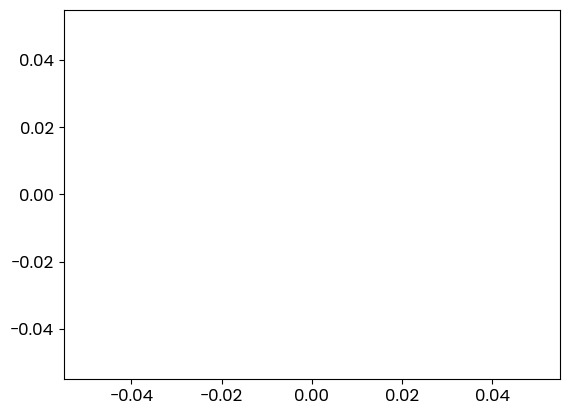

********** Convergence criteria not reached yet ********** 


Simulation 390 status: Discarded by random forest
Simulation 391 status: Discarded by random forest
Simulation 392 status: Discarded by random forest
Simulation 393 status: Accepted by random forest
Simulation 393 status: OK
Simulation 394 status: Discarded by random forest
Simulation 395 status: Discarded by random forest
Simulation 396 status: Accepted by random forest
Simulation 396 status: OK
Simulation 397 status: Discarded by random forest
Simulation 398 status: Discarded by random forest
Simulation 399 status: Discarded by random forest
Simulation 400 status: Discarded by random forest
Simulation 401 status: Discarded by random forest
Simulation 402 status: Accepted by random forest
Simulation 402 status: OK
Simulation 403 status: Accepted by random forest
Simulation 403 status: OK
Simulation 404 status: Discarded by random forest
Simulation 405 status: Discarded by random forest
Simulation 406 status: Discarded by ra

KeyboardInterrupt: 

In [3]:
# i-AOMA Phase 2 che parte dai risultati già immagazzinati della fase 1
print('\n\ni-AOMA phase 2: INTELLIGENT RANDOM FOREST DRIVEN MC SSI-cov SIMULATIONS\n')
starting_sim_num = [count_sim, len(discardedpar), count_sim_effective]
continueMCsim=1
# Initialize convergence check object which stores uncertainty propagation results 
modesconv = ConvCheck(kdeSD.Frequency_dataset, MAX_NUM_MC_SIM_PHASE_1)
last_check_sim = count_sim_effective

create_results_folder(RESULTS_PATH+'/Phase2')
create_results_folder(RESULTS_PATH+'/Phase2/Backup_convergence_checks') #???? not implemented for now because saving results will slow down the code

while continueMCsim and (count_sim_effective < (MAX_NUM_MC_SIM_PHASE_1 + MAX_NUM_MC_SIM_PHASE_2 -1)) :
    try:
        count_sim += 1
        sampledpar = Qmc.Halton() # it samples an array of [time shift, max order, window lenght, time target]
        y_pred = RF.predict( np.array(Qmc.retrieve_last_qmc_sampled()[0]) )
        if y_pred == 1:
            print(f'Simulation {count_sim} status: Accepted by random forest')
            # Run SSI-cov for a set of QMC Halton parameters with timeout of 30 seconds
            ssicovSD = SsiCov(dataslice(data, *sampledpar[0][2:]), fs, *sampledpar[0][:2])
            # If achieve here without any error, a new effective simulation is accounted
            count_sim_effective +=1
            # Normalize mode shapes
            ssicovSD.mode_normalization(NORMALIZDOF)
            # Retain only stable poles and associated mode shapes, convert the results in numpy arrays
            ssicovSD.retain_stable_poles(sim_num=count_sim_effective)

            SDresults.update_results(ssicovSD = ssicovSD, admissiblepar = np.array(Qmc.retrieve_last_qmc_sampled()[0]) )

            print(f'Simulation {count_sim} status: OK')
        else:
            print(f'Simulation {count_sim} status: Discarded by random forest')
            discardedpar.append(Qmc.retrieve_last_qmc_sampled()[0])
            discardedpar_errtype.append(f'Random forest prediction: 0')

    except Exception as e:
        if 'could not broadcast input array from shape' in str(e):
            print(f'Simulation {count_sim} status: ErrorType'+ ' ' + 'Incompatible parameters set')
        else:
            print(f'Simulation {count_sim} status: ErrorType'+ ' ' + str(e))
        discardedpar.append(Qmc.retrieve_last_qmc_sampled()[0])
        discardedpar_errtype.append(str(e))

    if ((count_sim_effective - starting_sim_num[2]) % BATCHNSIM == 0) and (count_sim_effective - starting_sim_num[2])!=0 \
        and (last_check_sim != count_sim_effective) :
        print('********** Check convergence criteria ********** \n')
        print(f'Actual simulations so far: {count_sim_effective+1}')

        create_results_folder(RESULTS_PATH+f'/Phase2/Backup_convergence_checks/{count_sim_effective+1}')

        
        #  create attribute which join in a single array poles and modes SDresults.jointpolesmodes
        SDresults.jointpolesarray_and_modesarray() # SDresults.joint_col_names [ ['Frequency', 'Order', 'Label', 'Damp', 'Emme', 'ModeNum', 'SimNumber'], ['SimNumber','dof','dof','...'] ]
        kdeSD.select_peaks_phase_two(SDresults.jointpolesmodes)
        kdeSD.plot_kde_freq(RESULTS_PATH+f'/Phase2/Backup_convergence_checks/{count_sim_effective+1}') # comment it after checking everything is correct 
        kdeSD.select_modes_clusters()
        kdeSD.plot_select_modes_clusters(RESULTS_PATH+f'/Phase2/Backup_convergence_checks/{count_sim_effective+1}') # comment it after checking everything is correct 

        convergence_reached = modesconv.update_converg_sim(kdeSD.Frequency_dataset, count_sim_effective, last_check_sim, CONVMCTHRESH)

        modesconv.plot_convergence_curves(CONVMCTHRESH, RESULTS_PATH+f'/Phase2/Backup_convergence_checks/{count_sim_effective+1}') # comment it after checking everything is correct 

        last_check_sim = count_sim_effective

        if convergence_reached:
            print('********** Stopping criteria reached! ********** \n\n')
            continueMCsim=0
        else:
            print('********** Convergence criteria not reached yet ********** \n\n')

    if count_sim_effective == (MAX_NUM_MC_SIM_PHASE_1 + MAX_NUM_MC_SIM_PHASE_2 -1):
        print('********** Convergence criteria not reached yet, but maximum allowed number of actual simulations reached ********** \n')

print(f'Simulations evaluated in total {count_sim+1}:\n' + \
      f'Phase 1: Simulations {starting_sim_num[0]+1}, discarding {starting_sim_num[1]}, collecting {MAX_NUM_MC_SIM_PHASE_1} useful results \n' + \
      f'Phase 2: Simulations {(count_sim-starting_sim_num[0])}, intelligently discarding {(len(discardedpar)-starting_sim_num[1])}, collecting {count_sim_effective-starting_sim_num[2]} useful results \n\n')

### Plotting and exporting results

In [ ]:
# Export results
RF.save_prediction_to_file(RESULTS_PATH+'/Phase2')
SDresults.plot_overlapped_SD(fs,PLOT_OVERLAPPED_SD, RESULTS_PATH+'/Phase2')
SDresults.plot_overlapped_SD_stable(fs,PLOT_OVERLAPPED_SD, RESULTS_PATH+'/Phase2')
SDresults.export_results_to_file(RESULTS_PATH+'/Phase2')
kdeSD.plot_kde_freq(RESULTS_PATH+'/Phase2') 
kdeSD.plot_select_modes_clusters(RESULTS_PATH+'/Phase2') 
print(f'Found {kdeSD.peaksFFTKDE.shape[0]:d} peaks at {kdeSD.x[kdeSD.peaksFFTKDE]} Hz with prominence of {kdeSD.KDEPROMINENCE:.4f}.\n')
print(f'Found {len(kdeSD.Frequency_dataset):d} poles clusters within {kdeSD.KDEbwFactor:d} times the bandwidth of {kdeSD.bw:.4f} Hz.\n')
# IC
IC_final = kdeSD.information_content(SDresults.selectedpoles_totnum)
kdeSD.save_plot_IC(count_sim_effective, ICTHRESH, RESULTS_PATH+'/Phase2')
kdeSD.export_results_to_file(RESULTS_PATH+'/Phase2')
modesconv.export_results_to_file(RESULTS_PATH+'/Phase2')

# Mode shape uncertainties analysis, saving and plotting final results
create_results_folder(RESULTS_PATH+'/Phase2/Mode_shapes')
create_results_folder(RESULTS_PATH+'/Phase2/Convergence_Analysis')
create_results_folder(RESULTS_PATH+'/Phase2/Intelligent_sampling_maps')

nodes = pd.read_csv(NODESFILE, header=None, sep="\s+", index_col=False).to_numpy()
connectivity = pd.read_csv(CONNECTIVITYFILE, header=None, sep="\s+", index_col=False).to_numpy()

modesconv.plot_mode_shapes(N_DIM, nodes, connectivity, MODESCALEFCT, MODESTDFCT, MODESTDFCT_ELLIPSES, MODE2D_DIRECTION, RESULTS_PATH+'/Phase2/Mode_shapes')
modesconv.plot_convergence_curves(CONVMCTHRESH, RESULTS_PATH+'/Phase2/Convergence_Analysis')
SDresults.plot_sampling_maps(RESULTS_PATH+'/Phase2/Intelligent_sampling_maps')

# End